In [3]:
data_path = '/home/oscar/Desktop/Exjobb/Data/ieee_supplement/Hyperspectral_Grids/Salinas/'

In [4]:
import numpy as np
import visdom
import utils
import seaborn as sns
from datasets import get_dataset, HyperX
import os
from sklearn import preprocessing
from sklearn.decomposition import PCA, FastICA
import random
from data_augmentation import RandAugment
from matplotlib import pyplot as plt

In [ ]:
vis = visdom.Visdom()

In [5]:
label_values = ["Undefined", "Brocoli_green_weeds_1", "Brocoli_green_weeds_2", "Fallow",
                        "Fallow_rough_plow", "Fallow_smooth", "Stubble",
                        "Celery", "Grapes_untrained", "Soil_vinyard_develop",
                        "Corn_senesced_green_weeds", "Lettuce_romaine_4wk", "Lettuce_romaine_5wk",
                        "Lettuce_romaine_6wk", "Lettuce_romaine_7wk", "Vinyard_untrained",
                        "Vinyard_vertical_trellis"]

palette = None
rgb_bands = (43, 21, 11)

if palette is None:
    # Generate color palette
    palette = {0: (0, 0, 0)}
    for k, color in enumerate(sns.color_palette("hls", len(label_values) - 1)):
        palette[k + 1] = tuple(np.asarray(255 * np.array(color), dtype='uint8'))
invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(x):
    return utils.convert_to_color_(x, palette=palette)
def convert_from_color(x):
    return utils.convert_from_color_(x, palette=invert_palette)

In [6]:
#train_patches = np.zeros(int((len(os.listdir(data_path + '/salinas_fold_0/'))-3)/2))
#train_gt = np.copy(train_patches)

train_patches = []
train_gt = []

for i in (range(int((len(os.listdir(data_path + '/salinas_fold_0/'))-3)/2))):
    #train_patches[i] = np.load(data_path + '/salinas_fold_0/patch_{}.npy'.format(i))
    #train_gt[i] = np.load(data_path + '/salinas_fold_0/patch_{}_gt.npy'.format(i))
    
    train_patches.append(np.load(data_path + '/salinas_fold_0/patch_{}.npy'.format(i)))
    train_gt.append(np.load(data_path + '/salinas_fold_0/patch_{}_gt.npy'.format(i)))

test = np.load(data_path + '/salinas_fold_0/test.npy')
test_gt = np.load(data_path + '/salinas_fold_0/test_gt.npy') 

In [57]:
randaugment = RandAugment(2, 10, 5)

In [62]:
test = train_patches[0][5:10,5:10,:]
test

array([[[297, 394, 586, ...,  26,   9,  15],
        [368, 394, 651, ...,  18,  13,  15],
        [297, 394, 586, ...,  18,  11,   9],
        [368, 394, 520, ...,  16,   0,   6],
        [368, 394, 586, ...,  12,   5,   6]],

       [[356, 486, 531, ...,  19,   7,  12],
        [285, 402, 662, ...,  21,   5,   8],
        [213, 402, 597, ...,  15,   3,   6],
        [285, 402, 597, ...,   5,   1,   2],
        [285, 319, 531, ...,   3,   1,   0]],

       [[291, 478, 602, ...,   8,   9,   8],
        [291, 394, 537, ...,   2,  -3,   8],
        [291, 394, 537, ...,   4,   3,   6],
        [291, 394, 537, ...,  16,   9,   0],
        [291, 394, 537, ...,  16,  -1,  10]],

       [[301, 312, 529, ...,   5,   9,  11],
        [301, 312, 595, ...,  15,   3,  13],
        [373, 396, 529, ...,  17,   5,   7],
        [230, 396, 529, ...,  21,   7,   7],
        [373, 479, 529, ...,  19,   9,  21]],

       [[373, 396, 599, ...,  25,   9,   5],
        [230, 312, 534, ...,  17,   7,  11],
  

In [98]:
aug_data = randaugment(train_patches[0][5:10,5:10,:])

<function moving_average at 0x7f8565917680>
<function spectral_mean at 0x7f85659175f0>


/home/oscar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


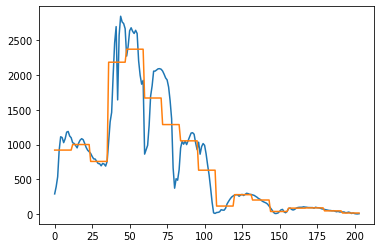

In [99]:
plt.plot(test[2,2,:])
plt.plot(aug_data[2,2,:])

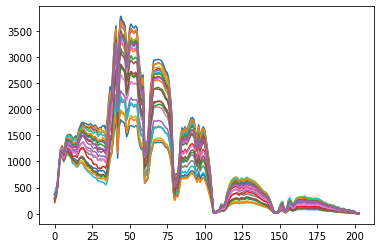

In [91]:
for x in range(test.shape[0]):
    for y in range(test.shape[1]):
        plt.plot(test[x,y,:])
#plt.plot(aug_data[2,2,:])

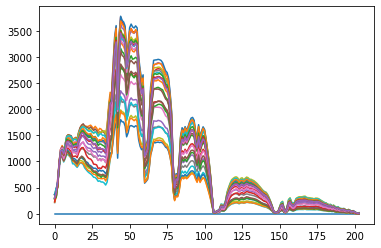

In [86]:
for x in range(test.shape[0]):
    for y in range(test.shape[1]):
        plt.plot(aug_data[x,y,:])

In [ ]:
A = np.array([[[1,2],[3,4]],[[5,6],[7,8]]])
np.flip(A, axis=-1)

In [ ]:
rgb_bands = (55, 41, 12)
label_values = ['Undefined', 'Asphalt', 'Meadows', 'Gravel', 'Trees',
                        'Painted metal sheets', 'Bare Soil', 'Bitumen',
                        'Self-Blocking Bricks', 'Shadows']
ignored_labels = [0]

palette = None

if palette is None:
    # Generate color palette
    palette = {0: (0, 0, 0)}
    for k, color in enumerate(sns.color_palette("hls", len(label_values) - 1)):
        palette[k + 1] = tuple(np.asarray(255 * np.array(color), dtype='uint8'))
invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(x):
    return utils.convert_to_color_(x, palette=palette)
def convert_from_color(x):
    return utils.convert_from_color_(x, palette=invert_palette)

img_unlabeled, gt, _, _, _, _ = get_dataset('PaviaC', target_folder='/home/oscar/Desktop/Exjobb/Data/')

utils.display_predictions(convert_to_color(gt[:,:]), vis, writer=None,
                                  caption="Test ground truth")

In [ ]:
gt.shape
utils.display_predictions(convert_to_color(gt[:,:223]), vis, writer=None,
                                  caption="Test ground truth")
utils.display_predictions(convert_to_color(gt[:,223:]), vis, writer=None,
                                  caption="Test ground truth")

In [ ]:
img_1 = img_unlabeled[:,:223,:]
img_1 = img_1.reshape(1, img_1.shape[0], img_1.shape[1], img_1.shape[2])
print(img_1[:,:,:,-1].shape)
print(img_1.shape)
img_1 = np.concatenate((img_1, img_1[:,:,:,-1, np.newaxis]), axis=-1)
img_1.shape

In [ ]:
mask = np.ones_like(train_gt)
print(np.count_nonzero(mask))
for i in range(len(mask)):
    mask[i, train_gt[i] == 0] = 0
print(np.count_nonzero(mask))
p,x,y = np.nonzero(mask)
print(str(p) + ' ' + str(x) + '' + str(y))
p_u, x_u, y_u = np.nonzero(mask==0)

In [ ]:
gt_np = np.array(train_gt)
train_np = np.array(train_patches)

In [ ]:
idx = set()

while len(idx) < 0.05*np.prod(gt_np.shape):
    p = np.random.randint(gt_np.shape[0])
    x = np.random.randint(gt_np.shape[1])
    y = np.random.randint(gt_np.shape[2])
    if (p,x,y) not in idx:
        idx.add((p,x,y))

In [ ]:
idx_np = np.array(list(idx))
idx_np

In [ ]:
train_np.shape

In [ ]:
ignored_labels = [0]
patch_size = 5

pad_width = patch_size // 2

train_np = np.pad(train_np, ((0,0), (pad_width, pad_width), (pad_width, pad_width), (0,0)))
gt_np = np.pad(gt_np, ((0,0), (pad_width, pad_width), (pad_width, pad_width)))

In [ ]:
mask = np.ones_like(gt_np)
for l in ignored_labels:
    mask[gt_np == l] = 0
patch_labeled, x_labeled, y_labeled = np.nonzero(mask)

for l in ignored_labels:
    patch_unlabeled, x_unlabeled, y_unlabeled = np.nonzero(mask==l)

p = patch_size // 2

indices_labeled = np.array([(p_l, x_l, y_l) for p_l, x_l, y_l in zip(patch_labeled, x_labeled, y_labeled) if x_l >= p and x_l < train_np.shape[1] - p and y_l >= p and y_l < train_np.shape[2] - p])
labels = [gt_np[p_l, x_l, y_l] for p_l, x_l, y_l in indices_labeled]

indices_unlabeled = np.array([(p_u, x_u, y_u) for p_u, x_u, y_u in zip(patch_unlabeled, x_unlabeled, y_unlabeled) if x_u >= p and x_u < train_np.shape[1] - p and y_u >= p and y_u < train_np.shape[2] - p])

indices_labeled_shuffle = np.copy(indices_labeled)
indices_unlabeled_shuffle = np.copy(indices_unlabeled)

np.random.shuffle(indices_labeled_shuffle)
np.random.shuffle(indices_unlabeled_shuffle)

In [ ]:
p, x, y = indices_labeled[0]

data = train_np[p, x-pad_width:x - pad_width + patch_size, y-pad_width:y-pad_width+patch_size]

label = gt_np[p, x-pad_width:x - pad_width + patch_size, y-pad_width:y-pad_width+patch_size]
labels[0]

In [ ]:
reshape = train_np.reshape(np.prod(train_np.shape[:3]), np.prod(train_np.shape[3:]))
scaler = preprocessing.MinMaxScaler()
reshape = scaler.fit_transform(reshape)
img_list = reshape.reshape(train_np.shape)

test = np.asarray(test, dtype='float32')
data_test = test.reshape(np.prod(test.shape[:2]), np.prod(test.shape[2:]))
data_test = scaler.transform(data_test)
test_patch = data_test.reshape(test.shape)

In [ ]:
np.max((test - np.min(train_np))/(np.max(train_np) - np.min(train_np)))

In [ ]:
x_size = train_np[0].shape[0]
y_size = train_np[0].shape[1]
data_train = np.array([train_np[p_l, x_l, y_l] for p_l, x_l, y_l in zip(patch_labeled, x_labeled, y_labeled) if x_l >= p and x_l < x_size - p and y_l >= p and y_l < y_size - p])

    
    

In [ ]:
pca = PCA(n_components=11)
pca.fit(data_train)

In [ ]:
data = pca.transform(data_train[0:2,:])

In [ ]:
(data*np.zeros(11))

In [ ]:
nalepa_classes = np.zeros(len(label_values))

for i in range(len(train_gt)):
    for c in range(len(nalepa_classes)):
        amount = np.count_nonzero(train_gt[i] == c)
        nalepa_classes[c] += amount

In [ ]:
print(nalepa_classes)

In [ ]:
print(np.sum(nalepa_classes[1:]))

In [ ]:
np.count_nonzero(gt_np) + np.count_nonzero(test_gt)

In [ ]:
np.shape(np.pad(train_patches, ((0,0), (2,2), (2,2), (0,0))))

In [ ]:
utils.display_predictions(convert_to_color(gt_5), vis)

In [ ]:
utils.display_dataset(patch_5, gt_5, rgb_bands, label_values, palette, vis)

In [ ]:
img, gt, label_values, ignored_labels, rgb_bands, palette = get_dataset('Salinas', target_folder='/home/oscar/Desktop/Exjobb/Data/')

In [ ]:
img.shape[1]

In [ ]:
patch_size = 5

In [ ]:
x = 0
y = 0

patch_list = []

while y in range(img.shape[1]):
    while x in range(img.shape[0]):
        if y + patch_size <= img.shape[1]: 
            if x + patch_size <= img.shape[0]:
                patch_list.append(img[x:x+patch_size, y:y+patch_size, :])
        '''
            else: 
                patch_list.append(img[x:, y:y+patch_size, :])
        else:
            if x + patch_size <= img.shape[0]:
                patch_list.append(img[x:x+patch_size, y:, :])
            else: 
                patch_list.append(img[x:, y:, :])
        '''
        x += patch_size
    y += patch_size
    x = 0

In [ ]:
x = 0
y = 0

gt_list = []

while y in range(gt.shape[1]):
    while x in range(gt.shape[0]):
        if y + patch_size <= gt.shape[1]: 
            if x + patch_size <= gt.shape[0]:
                gt_list.append(gt[x:x+patch_size, y:y+patch_size])
            #else: 
                #gt_list.append(gt[x:, y:y+patch_size])
        #else:
            #if x + patch_size <= gt.shape[0]:
                #gt_list.append(gt[x:x+patch_size, y:])
            #else: 
                #gt_list.append(gt[x:, y:])
        x += patch_size
    y += patch_size
    x = 0

In [ ]:
shape_list = []

for i in range(len(gt_list)):
    shape_list.append(np.shape(gt_list[i]))

In [ ]:
gt_list[1][3,3]

In [ ]:
utils.display_dataset(patch_list[453], gt_list[453], rgb_bands, label_values, palette, vis)

In [ ]:
utils.display_predictions(convert_to_color(gt_list[453]), vis)

In [ ]:
gt_list[453][3,3]

In [ ]:
class_list = np.zeros(len(label_values))
gt_center = np.zeros(len(gt_list))

for i in range(len(gt_list)):
    c = gt_list[i][3,3]
    class_list[c] += 1
    gt_center[i] = c

In [ ]:
print(class_list)

In [ ]:
print(np.sum(class_list[1:]))

In [ ]:
np.argmax(np.bincount(gt_list[352].flatten()))

In [ ]:
class_major_list = np.zeros(len(label_values))
gt_major = np.zeros(len(gt_list))

for i in range(len(gt_list)):
    amount = np.bincount(gt_list[i].flatten())
    c = np.argmax(amount)
    class_major_list[c] += 1
    gt_major[i] = c

In [ ]:
print(class_major_list)

In [ ]:
print(np.sum(class_major_list[1:]))

In [ ]:
from datasets import get_patch_data, get_pixel_idx, HyperX_patches
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
from torch.nn import init
from torch.autograd import Variable
import torch.utils.data as data

In [ ]:
from models import HamidaEtAl, NalepaEtAl
import math
from matplotlib import pyplot as plt

In [ ]:
data_path = '/home/oscar/Desktop/Exjobb/Data/ieee_supplement/Hyperspectral_Grids/Pavia\ University/'

In [ ]:
train_img, train_gt, test_img, test_gt, label_values, ignored_labels, rgb_bands, palette = get_patch_data('Salinas', 1, target_folder=data_path, fold=1)


In [ ]:
n_bands = train_img.shape[-1]
n_classes = len(label_values) - len(ignored_labels)

In [ ]:
model = HamidaEtAl(n_bands, n_classes,
                       patch_size=5)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,
                          nesterov=True)

In [ ]:
idx_sup, idx_val, idx_unsup = get_pixel_idx(train_img, train_gt, ignored_labels, 5)


In [ ]:
train_labeled_gt = [train_gt[p_l, x_l, y_l] for p_l, x_l, y_l in idx_sup]
samples_class = np.zeros(n_classes)
for c in np.unique(train_labeled_gt):
    samples_class[c-1] = np.count_nonzero(train_labeled_gt == c)

In [ ]:
hyperparams = {'patch_size': 1, 'dataset': 'Salinas', 'ignored_labels': ignored_labels, 
               'flip_augmentation': True, 'radiation_augmentation': False, 'mixture_augmentation': False,
              'center_pixel': True, 'supervision': 'full', 'pca_augmentation': False, 'pca_strength': 1, 'cutout_spatial': False,
              'cutout_spectral': False, 'augmentation_magnitude': 1, 'spatial_combinations': False, 'spectral_mean': False,
              'moving_average': False}

val_dataset = HyperX_patches(train_img, train_gt, idx_val, labeled=True, **hyperparams)
val_loader = data.DataLoader(val_dataset, batch_size=10)

train_labeled_dataset = HyperX_patches(train_img, train_gt, idx_sup, labeled=True, **hyperparams)
train_labeled_loader = data.DataLoader(train_labeled_dataset, batch_size=10,
                                       #pin_memory=True, num_workers=5,
                                       shuffle=True, drop_last=True)

unlabeled_ratio = math.ceil(len(idx_unsup)/len(idx_sup))

train_unlabeled_dataset = HyperX_patches(train_img, train_gt, idx_unsup, labeled=False, **hyperparams)
train_unlabeled_loader = data.DataLoader(train_unlabeled_dataset, batch_size=10*unlabeled_ratio,
                                       #pin_memory=True, num_workers=5,
                                       shuffle=True, drop_last=True)
amount_labeled = idx_sup.shape[0]

In [ ]:
data = train_img[idx_unsup[0][0], 0:5:, 9:14]
data_aug = np.zeros_like(data)
data_train = data - np.mean(data, axis=(0,1,2))
for x,y in np.ndenumerate(data[:,:,0]):
    print(x)
    print(y)

In [ ]:
new_data = np.copy(data)
M=4
bands = 2*M
channels = data.shape[-1]
chunks = channels/bands
print(chunks)
for i in range(math.ceil(chunks)):
    print(i)
    print(channels*i/chunks)
    print(int(channels*(i+1)/chunks))
    print(new_data[:,:,int(channels*i/chunks):int(channels*(i+1)/chunks)].shape)
    print(np.stack((np.mean(data[:,:,int(channels*i/chunks):int(channels*(i+1)/chunks)], axis=2) for _ in range(new_data[:,:,int(channels*i/chunks):int(channels*(i+1)/chunks)].shape[-1])), axis=2).shape)
    new_data[:,:,int(channels*i/chunks):int(channels*(i+1)/chunks)] = np.stack((np.mean(data[:,:,int(channels*i/chunks):int(channels*(i+1)/chunks)], axis=2) for _ in range(new_data[:,:,int(channels*i/chunks):int(channels*(i+1)/chunks)].shape[-1])), axis=2)

In [ ]:
print(next(iter(train_labeled_loader))[0].shape)
print(next(iter(train_unlabeled_loader))[0].shape)
print(next(iter(train_unlabeled_loader))[1].shape)

In [ ]:
new_data = np.copy(data)
M=1
channels = data.shape[-1]
for i in range(channels):
    c1 = np.clip(i-M, 0, channels)
    c2 = np.clip(i+M, 0, channels)
    new_data[:,:,i] = np.mean(data[:,:,c1:c2], axis=2)

In [ ]:
meeen= np.mean(data[:,:,0:2], axis=2)

In [ ]:
alphas = np.random.uniform(0.01, 1, size=0)
print(alphas.size == 0)

In [ ]:
h, w, c = data.shape
size=1
print(data.shape)
new_image = np.zeros_like(data)
for x in range(h):
    for y in range(w):
        x1 = np.clip(x - size // 2, 0, h)
        x2 = np.clip(x + size // 2 + 1, 0, h)
        y1 = np.clip(y - size // 2, 0, w)
        y2 = np.clip(y + size // 2 + 1,  0, w)
        print((x,y))
        print((x1,x2))
        print((y1,y2))
        patch = data[x1:x2, y1:y2, :]
        print(patch.shape)
        patch = patch.reshape(np.prod(patch.shape[:2]), c)
        print(patch.shape)
        delete_idx = []
        for p in range(patch.shape[0]):
            if np.sum(patch[p,:])==0:
                delete_idx.append(p)
        patch = np.delete(patch, delete_idx, 0)
        print(patch.shape)
        alphas = np.random.uniform(0.01, 1, size=patch.shape[0])
        new_image[x,y,:] = np.dot(np.transpose(patch), alphas)/np.sum(alphas)

In [ ]:
centered_data = train_img - np.mean(train_img, axis=(0,1,2))
train_data = np.array([centered_data[p,x,y] for p,x,y in idx_sup])

In [ ]:
ipca = PCA(n_components=11)
pca.fit(train_data)

In [ ]:
plt.plot(pca.components_[0])

In [ ]:
to_transform = train_data[0,:]
data = pca.transform(to_transform.reshape(-1,1))
new_data = np.copy(data)
new_data[:,0] = data[:,0]*10
print(np.mean(new_data-data))
transformed = pca.inverse_transform(new_data)
print(np.mean(transformed - to_transform))

In [ ]:
train_gt, test_gt = utils.sample_gt(gt, 0.3,
                                        mode='disjoint')

train_gt, val_gt = utils.sample_gt(train_gt, 0.95, mode='disjoint')

val_dataset = HyperX(img, val_gt, labeled=True, **hyperparams)
val_loader = data.DataLoader(val_dataset,
                             batch_size=10)

train_labeled_gt, train_unlabeled_gt = utils.sample_gt(train_gt, 1/(7 + 1),
                                                        mode='disjoint')

samples_class = np.zeros(n_classes)
for c in np.unique(train_labeled_gt):
    samples_class[c-1] = np.count_nonzero(train_labeled_gt == c)

train_labeled_dataset = HyperX(img, train_labeled_gt, labeled=True, **hyperparams)
train_labeled_loader = data.DataLoader(train_labeled_dataset, batch_size=10,
                                       #pin_memory=True, num_workers=5,
                                       shuffle=True, drop_last=True)

train_unlabeled_dataset = HyperX(img, train_unlabeled_gt, labeled=False, **hyperparams)
train_unlabeled_loader = data.DataLoader(train_unlabeled_dataset,
                                         batch_size=10*7,
                                         #pin_memory=True, num_workers=5,
                                         shuffle=True, drop_last=True)

In [ ]:
samples_labeled = []

for i in range(train_labeled_dataset.__len__()):
    samples_labeled.append(train_labeled_dataset.__getitem__(i)[0])

In [ ]:
samples_labeled[0]

In [ ]:
samples_train = []

for i in range(train_dataset.__len__()):
    samples_train.append(train_dataset.__getitem__(i)[0])

In [ ]:
samples_train[0]

In [ ]:
np.max(test_img)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test_gt.flatten(), test_gt.flatten()))

In [ ]:
for i in range(0,5):
    print(i)

In [ ]:
x_train, y_train = utils.build_dataset(train_img, train_gt, ignored_labels=ignored_labels)

In [ ]:
import sklearn.svm as SVM

In [ ]:
clf = SVM.SVC(class_weight='balanced')
clf.fit(x_train, y_train)
prediction = clf.predict(test_img.reshape(-1, n_bands))
prediction = prediction.reshape(test_img.shape[:2])

In [ ]:
run_results = utils.metrics(prediction, test_gt, ignored_labels=ignored_labels, n_classes=n_classes)

mask = np.zeros(test_gt.shape, dtype='bool')
for l in ignored_labels:
    mask[test_gt == l] = True
prediction[mask] = 0

color_prediction = convert_to_color(prediction)
utils.display_predictions(color_prediction, vis, gt=convert_to_color(test_gt), caption="Prediction vs. test ground truth")

utils.show_results(run_results, vis, label_values=label_values)

In [ ]:
unique_labels = np.zeros(len(label_values))
new_idx_sup = []
index = 0
for p,x,y in idx_sup:
    label = train_gt[p,x,y]
    if unique_labels[label] < 10:
        unique_labels[label] += 1
        new_idx_sup.append([p,x,y])
        np.delete(idx_sup, index)
    index += 1

In [ ]:
np.asarray(new_idx_sup).shape

In [ ]:
idx_sup

In [ ]:
new_idx_unsup = np.concatenate((idx_sup, idx_unsup))

In [ ]:
new_idx_unsup.shape

In [ ]:
data_path = '/home/oscar/Desktop/Exjobb/Data/ieee_supplement/Hyperspectral_Grids/Pavia University'
train_img, train_gt, test_img, test_gt, label_values, ignored_labels, rgb_bands, palette = get_patch_data('Pavia', 5, target_folder=data_path)

In [ ]:
import importlib
import models
from tqdm import tqdm

In [ ]:
models = importlib.reload(models)

In [ ]:
model = models.NalepaEtAl(n_bands, n_classes)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,
                          nesterov=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
for e in range(5):
    model.train()
    for idx, (data, target) in enumerate(train_labeled_loader):
        target = target - 1
        output = model(data)
        loss = criterion(output, target)
        print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

In [ ]:
def test(net, img, hyperparams):
    """
    Test a model on a specific image
    """
    net.eval()
    patch_size = hyperparams['patch_size']
    center_pixel = hyperparams['center_pixel']
    batch_size, device = hyperparams['batch_size'], hyperparams['device']
    n_classes = hyperparams['n_classes']

    kwargs = {'step': hyperparams['test_stride'], 'window_size': (patch_size, patch_size)}
    probs = np.zeros(img.shape[:2] + (n_classes,))

    iterations = utils.count_sliding_window(img, **kwargs) // batch_size
    for batch in tqdm(utils.grouper(batch_size, utils.sliding_window(img, **kwargs)),
                      total=(iterations), desc="Inference on the image"):
        with torch.no_grad():
            if patch_size == 1:
                data = [b[0][0, 0] for b in batch]
                data = np.copy(data)
                data = torch.from_numpy(data)
            else:
                data = [b[0] for b in batch]
                data = np.copy(data)
                data = data.transpose(0, 3, 1, 2)
                data = torch.from_numpy(data)
                data = data.unsqueeze(1)

            indices = [b[1:] for b in batch]
            data = data.to(device)
            output = net(data)
            if isinstance(output, tuple):
                output = output[0]
            output = output.to('cpu')

            if patch_size == 1 or center_pixel:
                output = output.numpy()
            else:
                output = np.transpose(output.numpy(), (0, 2, 3, 1))
            for (x, y, w, h), out in zip(indices, output):
                if center_pixel:
                    probs[x + w // 2, y + h // 2] += out
                else:
                    probs[x:x + w, y:y + h] += out
    return probs

In [ ]:
hyperparams = {'patch_size': 1, 'dataset': 'Salinas', 'ignored_labels': ignored_labels, 
               'flip_augmentation': True, 'radiation_augmentation': False, 'mixture_augmentation': False,
              'center_pixel': True, 'supervision': 'full', 'pca_augmentation': False, 'pca_strength': 1, 'cutout_spatial': False,
              'cutout_spectral': False, 'augmentation_magnitude': 1, 'spatial_combinations': False, 'spectral_mean': False,
              'moving_average': False, 'batch_size': 10, 'device': 'cpu', 'n_classes': n_classes, 'test_stride': 1}

In [ ]:
probabilities = test(model, test_img, hyperparams)
prediction = np.argmax(probabilities, axis=-1)

In [ ]:
prediction

In [ ]:
run_results = utils.metrics(prediction, test_gt, ignored_labels=ignored_labels, n_classes=n_classes)

mask = np.zeros(test_gt.shape, dtype='bool')
prediction
for l in ignored_labels:
    mask[test_gt == l] = True
prediction += 1
prediction[mask] = 0

color_prediction = convert_to_color(prediction)
utils.display_predictions(color_prediction, vis, gt=convert_to_color(test_gt), caption="Prediction vs. test ground truth")

utils.show_results(run_results, vis, label_values=label_values)

In [ ]:
x = data.squeeze(dim=-1).squeeze(dim=-1)

In [ ]:
x.unsqueeze(1).shape

In [ ]:
c = np.zeros((10,8))
a = np.array([(0,x,y) for x in range(c.shape[0]) for y in range(c.shape[1])])
a

In [ ]:
a = [1,2,3,4]
b = [5,6]

for idx,(i,j) in enumerate(zip(a,b)):
    print(idx)
    print(i)
    print(j)

In [ ]:
np.random.randint(5)

In [ ]:
[a[p,x,y) for p,x,y in [(0,0,0), (1,1,1), (2,2,2)]]